<a href="https://colab.research.google.com/github/BryanSouza91/COVID-19/blob/master/COVID19_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [0]:
tf.random.set_seed(29)

In [0]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [0]:
conf_df = pd.read_csv(confirmed_url)
recv_df = pd.read_csv(recovered_url)
death_df = pd.read_csv(deaths_url)

In [6]:
print(conf_df.loc[:,'1/22/20':].sum().tail())
print(recv_df.loc[:,'1/22/20':].sum().tail())
print(death_df.loc[:,'1/22/20':].sum().tail())

4/11/20    1771514
4/12/20    1846679
4/13/20    1917319
4/14/20    1976191
4/15/20    2056054
dtype: int64
4/11/20    402110
4/12/20    421722
4/13/20    448655
4/14/20    474261
4/15/20    511019
dtype: int64
4/11/20    108503
4/12/20    114091
4/13/20    119482
4/14/20    125984
4/15/20    134177
dtype: int64


In [7]:
print("New cases as of {}: {}".format(conf_df.columns[-1],(conf_df.loc[::].sum()[-1] - conf_df.loc[::].sum()[-2])))
print("New case rate: {0:.3%}".format((conf_df.loc[::].sum()[-1] - conf_df.loc[::].sum()[-2])/ conf_df.loc[::].sum()[-2]))
print("Death rate: {0:.3%}".format(death_df.loc[::].sum()[-1]/conf_df.loc[::].sum()[-1]))

New cases as of 4/15/20: 79863
New case rate: 4.041%
Death rate: 6.526%


In [0]:
def standardize(x, mean, std):
  return (x - mean) / std

def inv_standardize(x, mean, std):
  return (x * std) + mean

In [0]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [10]:
# define input sequence

raw_seq = np.log10(conf_df.loc[:,'1/22/20':].sum().values)

# get mean and std
TRAIN_SPLIT = int(len(raw_seq)*.8)
print(TRAIN_SPLIT)
MEAN = raw_seq[:TRAIN_SPLIT].mean()
STD = raw_seq[:TRAIN_SPLIT].std()
stand_seq = standardize(raw_seq, MEAN, STD)

# choose a number of time steps

n_steps_in, n_steps_out = 9, 3

# split into samples

X, y = split_sequence(stand_seq, n_steps_in, n_steps_out)

for i in range(len(X)):
  print(X[i], y[i])

68
[-2.89873887 -2.7965028  -2.56988338 -2.30748422 -2.0645653  -1.86306591
 -1.46141203 -1.39898879 -1.2188437 ] [-1.10237701 -0.98228302 -0.77515875]
[-2.7965028  -2.56988338 -2.30748422 -2.0645653  -1.86306591 -1.46141203
 -1.39898879 -1.2188437  -1.10237701] [-0.98228302 -0.77515875 -0.66979562]
[-2.56988338 -2.30748422 -2.0645653  -1.86306591 -1.46141203 -1.39898879
 -1.2188437  -1.10237701 -0.98228302] [-0.77515875 -0.66979562 -0.55532658]
[-2.30748422 -2.0645653  -1.86306591 -1.46141203 -1.39898879 -1.2188437
 -1.10237701 -0.98228302 -0.77515875] [-0.66979562 -0.55532658 -0.46467564]
[-2.0645653  -1.86306591 -1.46141203 -1.39898879 -1.2188437  -1.10237701
 -0.98228302 -0.77515875 -0.66979562] [-0.55532658 -0.46467564 -0.39725908]
[-1.86306591 -1.46141203 -1.39898879 -1.2188437  -1.10237701 -0.98228302
 -0.77515875 -0.66979562 -0.55532658] [-0.46467564 -0.39725908 -0.3284484 ]
[-1.46141203 -1.39898879 -1.2188437  -1.10237701 -0.98228302 -0.77515875
 -0.66979562 -0.55532658 -0.464

In [11]:
# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 1

X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(74, 9, 1)

In [0]:
# define model

def get_compiled_model(n_steps_in, n_steps_out, n_features):
  model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(96, 2, activation='elu', input_shape=(n_steps_in, n_features)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(32, 2, activation='elu'),
    tf.keras.layers.MaxPooling1D(1),
    tf.keras.layers.Conv1D(32, 1, activation='elu'),
    tf.keras.layers.MaxPooling1D(1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='elu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.Dense(n_steps_out)
  ])

  model.compile(optimizer='adam', loss='mae')

  return model

In [13]:
model = get_compiled_model(n_steps_in,n_steps_out,n_features)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 8, 96)             288       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 96)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 32)             6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 32)             1056      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0

In [0]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.9, patience=6, min_lr=1e-7, verbose=1)

In [15]:
# fit model
hist = model.fit(X, y, validation_split=.2, epochs=200, verbose=1, shuffle=True, callbacks=[early_stop])

Epoch 1/200
2/2 [==============================] - 0s 122ms/step - loss: 0.5058 - val_loss: 0.1175
Epoch 2/200
2/2 [==============================] - 0s 26ms/step - loss: 0.2650 - val_loss: 0.9409
Epoch 3/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1998 - val_loss: 0.3129
Epoch 4/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1405 - val_loss: 0.2090
Epoch 5/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1297 - val_loss: 0.3602
Epoch 6/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1185 - val_loss: 0.3720
Epoch 7/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1050 - val_loss: 0.1409
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0772 - val_loss: 0.2092
Epoch 9/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0814 - val_loss: 0.2409
Epoch 10/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0713 - val_loss: 0.3435
Epoch 11/200
2/2 [

In [16]:
# demonstrate prediction
x_input = np.log10(conf_df.loc[:,'1/22/20':].sum()[-(n_steps_in+1):-1].to_numpy())
x_inMEAN = x_input.mean()
x_inSTD = x_input.std()
x_input = standardize(x_input, x_inMEAN, x_inSTD)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
yhat = inv_standardize(yhat, x_inMEAN, x_inSTD)
print("Prediction: {0:.0f} True: {1:.0f}".format((10 ** yhat[0][-1]), (10 ** raw_seq[-1])))
PE = (((10 ** yhat[0][-1] - 10 ** raw_seq[-1])/10 ** raw_seq[-1]))
print("Percent Error: {0:.3%}".format(PE))

Prediction: 2123646 True: 2056054
Percent Error: 3.287%


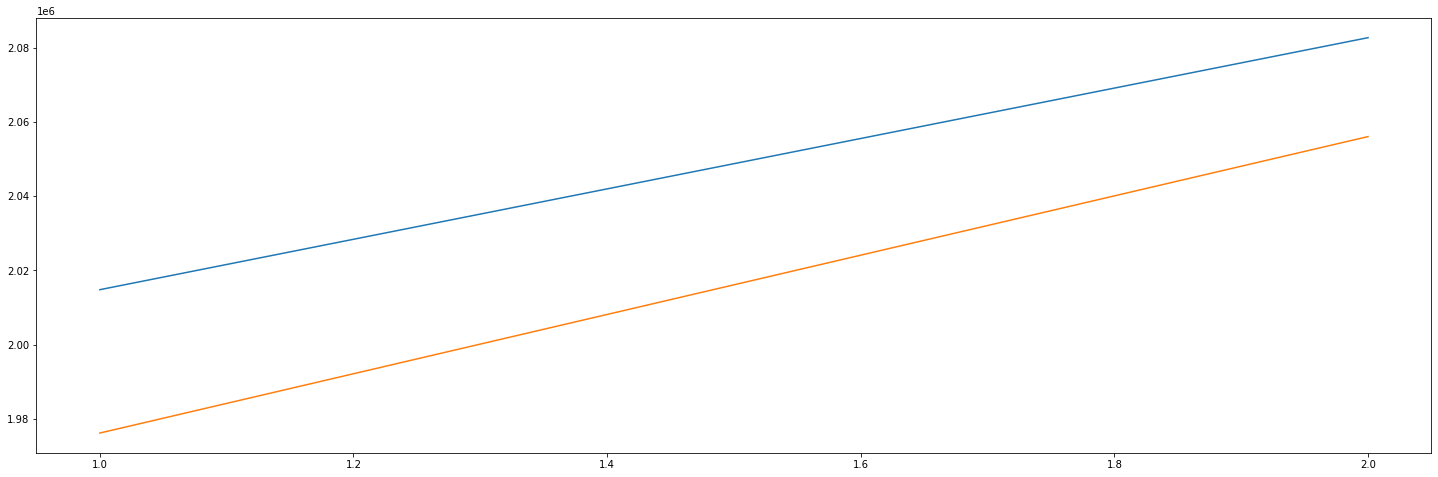

In [17]:
plt.figure(figsize=(25,8))
sns.lineplot([n for n in range(1,3)],[10**n for n in yhat[0][:2]]);
sns.lineplot([n for n in range(1,3)],conf_df.loc[:,'1/22/20':].sum()[-3:].to_numpy()[1:]);

In [18]:
# prediction for tomorrow
x_input = np.log10(conf_df.loc[:,'1/22/20':].sum()[-n_steps_in:].to_numpy())
x_inMEAN = x_input.mean()
x_inSTD = x_input.std()
x_input = standardize(x_input, x_inMEAN, x_inSTD)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
yhat = inv_standardize(yhat, x_inMEAN, x_inSTD)
print("%d" % (10 ** yhat[0][-1]))

2188134


In [19]:
for pred in yhat[0]:
  print("%d" % (10 ** pred))

2083668
2148348
2188134


In [0]:
hist = pd.DataFrame(hist.history)

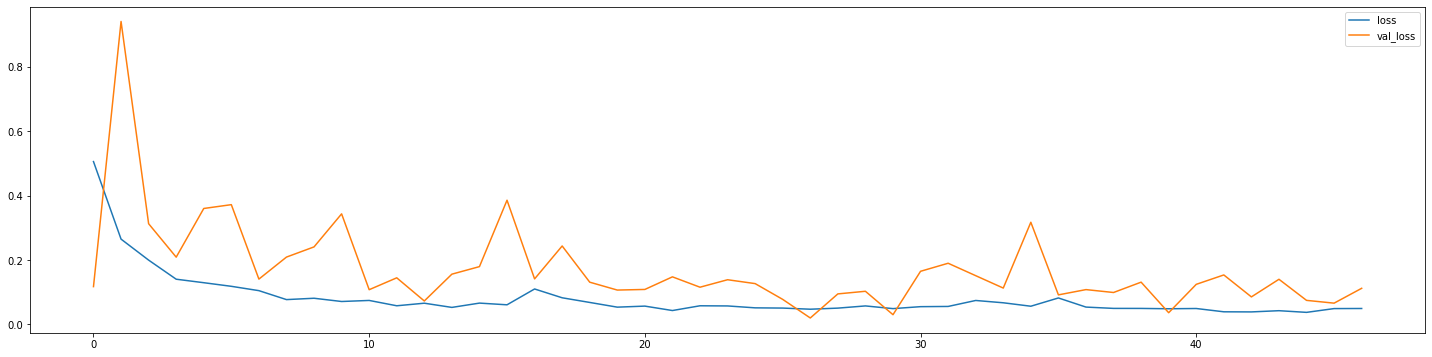

In [21]:
hist.plot(figsize=(25,6));

In [22]:
[n for n in range(1,4)],[10**n for n in yhat[0]],conf_df.loc[:,'1/22/20':].sum()[-3:].to_numpy()

([1, 2, 3],
 [2083668.2911156774, 2148348.2524591302, 2188134.7453796696],
 array([1917319, 1976191, 2056054]))